<a href="https://colab.research.google.com/github/sefeoglu/AE_Parseval_Network/blob/master/src/notebooks/ResNet_Tensorflow_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wide ResNet 16_2

In [62]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, EarlyStopping
import tensorflow

print("\nTensorflow Version: " + tf.__version__)


Tensorflow Version: 2.2.0


# Model

In [88]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import warnings

warnings.filterwarnings("ignore")
weight_decay = 0.0001


def initial_conv(input):
  
    x = Convolution2D(16, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(input)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    return x


def expand_conv(init, base, k, strides=(1, 1)):
    x = Convolution2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = Convolution2D(base * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    skip = Convolution2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    m = Add()([x, skip])

    return m


def conv1_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    print("conv2:channel:  {}".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    print("conv3 channel_axis:{} ".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def create_wide_residual_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1):
    """
    Creates a Wide Residual Network with specified parameters

    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)

    x = initial_conv(ip)
    nb_conv = 4

    x = expand_conv(x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)

    x = Dense(nb_classes, kernel_regularizer=l2(weight_decay), activation='softmax')(x)

    model = Model(ip, x)

    if verbose: print("Wide Residual Network-%d-%d created." % (nb_conv, k))
    return model
if __name__ == "__main__":
  init = (32, 32,1)
  wrn_16_2 = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout=0.5)


conv2:channel:  -1
conv3 channel_axis:-1 
Wide Residual Network-16-2 created.


# Data Prepare and Processing




In [64]:
from sklearn.model_selection import train_test_split
import gzip
import pickle

import numpy as np

In [65]:
def read_data():
    with open("data.pz", 'rb') as file_:
        with gzip.GzipFile(fileobj=file_) as gzf:
            data = pickle.load(gzf, encoding='latin1', fix_imports=True)
    return data
data = read_data()


In [66]:
import cv2
new_data_X = []
Y_data = []
for row in data:
    new_data_X.append(cv2.resize(row['crop'], (32,32)))
    Y_data.append(row['label'])
new_data_X = np.array(new_data_X)
new_data_X.shape

(5722, 32, 32)

In [67]:
X = new_data_X.astype('float32')
X.shape

(5722, 32, 32)

# Preprocessing

In [68]:
img_rows, img_cols = X[0].shape

# transform data set
if K.image_data_format() == 'channels_first':
    X = X.reshape(X.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X = X.reshape(X.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [69]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
y_df = pd.DataFrame(Y_data, columns=['Label'])
y_df['Encoded'] = labelencoder.fit_transform(y_df['Label'])

In [70]:
from tensorflow.keras.utils import to_categorical

y_cat = to_categorical(y_df['Encoded'])

In [71]:
X_train, X_test, Y_train, y_test = train_test_split(X, y_cat, test_size = 0.1)
x_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.1)

# Training

In [72]:
def lr_sch(epoch):
    if epoch < 30:
        return 0.1
    elif epoch < 50:
        return 0.001
    elif epoch < 60:
        return 0.001
    else:
        return 0.00001

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_sch)

In [73]:
generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                               width_shift_range=5./32,
                               height_shift_range=5./32,)

In [92]:
from sklearn.model_selection import  KFold

class Non_adversarial(object):
  def __init__(self):
    pass

  def train_iterate(self, X_train, Y_train, X_test, y_test, epochs, BS,sgd, epsilon_list):
          init = (32, 32,1)
          res_df = pd.DataFrame(columns=['loss_clean','acc_clean',
                                  'loss1', 'acc1','loss2', 'acc2','loss3',
                                    'acc3','loss4', 'acc4'])
          kf = KFold(n_splits=3, random_state=42, shuffle=False)
          
          for j, (train, val) in enumerate(kf.split(X_train)):
            x_train, y_train,  x_val, y_val = X_train[train], Y_train[train], X_train[val], Y_train[val]
            model = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout=0.5)

            model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
            hist = model.fit(generator.flow(x_train, y_train, batch_size=BS), steps_per_epoch=len(x_train) // BS, epochs=epochs,
                            callbacks = [lr_scheduler],
                            validation_data=(x_val, y_val),
                            validation_steps=x_val.shape[0] // BS,)
            loss, acc = model.evaluate(X_test, y_test)
            loss1, acc1 = print_test(model, get_adversarial_examples(model, X_test, y_test, epsilon_list[0]),X_test, y_test, epsilon_list[0])
            loss2, acc2 = print_test(model, get_adversarial_examples(model, X_test, y_test, epsilon_list[1]),X_test, y_test, epsilon_list[1])
            loss3, acc3 = print_test(model, get_adversarial_examples(model, X_test, y_test, epsilon_list[2]),X_test, y_test, epsilon_list[2])
            loss4, acc4 = print_test(model, get_adversarial_examples(model, X_test, y_test, epsilon_list[3]),X_test, y_test, epsilon_list[3])
            row = {'loss_clean':loss,'acc_clean':acc, 'loss1':loss1, 'acc1':acc1, 'loss2':loss2,
                    'acc2':acc2, 'loss3':loss3, 'acc3':acc3, 'loss4':loss4, 'acc4':acc4}
            res_df = res_df.append(row , ignore_index=True)
            
          return res_df

In [ ]:

!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

import cleverhans

print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

In [76]:
from cleverhans.future.tf2.attacks import fast_gradient_method

def get_adversarial_examples(pretrained_model, X_true, y_true, epsilon):
  #The attack requires the model to ouput the logits
   
  logits_model = tf.keras.Model(pretrained_model.input,pretrained_model.layers[-1].output)
  X_adv = []
  for i in range(len(X_true)):
    random_index = i
    original_image = X_true[random_index]
    original_image = tf.convert_to_tensor(original_image.reshape((1,32,32))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    original_label = y_true[random_index]
    original_label = np.reshape(np.argmax(original_label), (1,)).astype('int64')
    adv_example_targeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf,y=original_label, targeted=False)
    X_adv.append(np.array(adv_example_targeted_label).reshape(32,32,1))
  X_adv = np.array(X_adv)
  return X_adv



In [77]:
import matplotlib.pyplot as plt

def show_graph(hist):
  history = hist
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.savefig("wrn_tensor.png")
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.savefig("deneme.png")

In [78]:
def print_test(model,X_adv, X_test, y_test, epsilon):
  loss, acc = model.evaluate(X_adv,y_test)
  print("epsilon: {} and test evaluation : {}, {}".format(epsilon,loss, acc))
  SNR = 20*np.log10(np.linalg.norm(X_test)/np.linalg.norm(X_test-X_adv))
  print("SNR: {}".format(SNR))
  return loss, acc

**Train a Model**

In [90]:
EPOCHS = 70
BS = 128
sgd = SGD(lr=0.1, momentum=0.6)

In [91]:
#wrn_16_2.summary()
wrn_16_2.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")

hist = wrn_16_2.fit(generator.flow(x_train, y_train, batch_size=BS), steps_per_epoch=len(x_train) // BS, epochs=EPOCHS,
                   callbacks = [lr_scheduler],
                   validation_data=(X_val, y_val),
                   validation_steps=X_val.shape[0] // BS,)
wrn_16_2.save("wrn_model.h5")


Finished compiling
Epoch 1/70
36/36 [==============================] - 2s 60ms/step - loss: 1.4775 - acc: 0.3759 - val_loss: 1.4742 - val_acc: 0.3495 - lr: 0.1000
Epoch 2/70
36/36 [==============================] - 2s 53ms/step - loss: 1.4553 - acc: 0.3837 - val_loss: 1.4557 - val_acc: 0.3650 - lr: 0.1000
Epoch 3/70
36/36 [==============================] - 2s 50ms/step - loss: 1.4437 - acc: 0.3890 - val_loss: 1.4695 - val_acc: 0.3922 - lr: 0.1000
Epoch 4/70
36/36 [==============================] - 2s 51ms/step - loss: 1.4332 - acc: 0.4008 - val_loss: 1.4591 - val_acc: 0.3942 - lr: 0.1000
Epoch 5/70
36/36 [==============================] - 2s 51ms/step - loss: 1.4251 - acc: 0.4037 - val_loss: 1.4508 - val_acc: 0.3767 - lr: 0.1000
Epoch 6/70
36/36 [==============================] - 2s 50ms/step - loss: 1.4249 - acc: 0.4095 - val_loss: 1.4544 - val_acc: 0.4058 - lr: 0.1000
Epoch 7/70
36/36 [==============================] - 2s 51ms/step - loss: 1.4043 - acc: 0.4356 - val_loss: 1.4425 - va

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


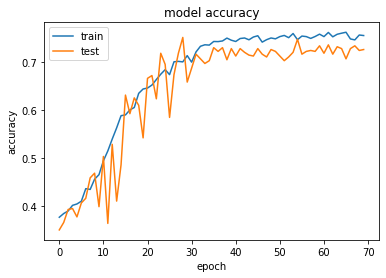

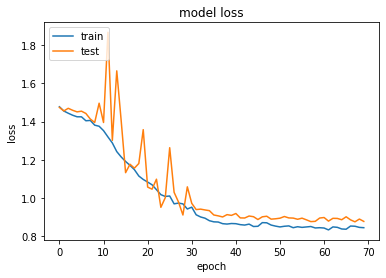

<Figure size 432x288 with 0 Axes>

In [93]:
show_graph(hist)

# Adversarial Examples


**Non_Adversarial Training Test**

In [94]:
epsilon_list = [0.003,0.005,0.01,0.02]
train_object = Non_adversarial()
sgd = SGD(lr=0.1, momentum=0.6)
result_df = train_object.train_iterate(X_train, Y_train, X_test, y_test, EPOCHS, BS,sgd, epsilon_list)

conv2:channel:  -1
conv3 channel_axis:-1 
Wide Residual Network-16-2 created.
Epoch 1/70
26/26 [==============================] - 2s 72ms/step - loss: 1.6027 - acc: 0.3087 - val_loss: 1.5699 - val_acc: 0.3564 - lr: 0.1000
Epoch 2/70
26/26 [==============================] - 1s 56ms/step - loss: 1.5364 - acc: 0.3611 - val_loss: 1.5548 - val_acc: 0.3244 - lr: 0.1000
Epoch 3/70
26/26 [==============================] - 1s 57ms/step - loss: 1.4924 - acc: 0.3711 - val_loss: 1.4825 - val_acc: 0.3722 - lr: 0.1000
Epoch 4/70
26/26 [==============================] - 1s 55ms/step - loss: 1.4876 - acc: 0.3768 - val_loss: 1.5030 - val_acc: 0.3559 - lr: 0.1000
Epoch 5/70
26/26 [==============================] - 1s 56ms/step - loss: 1.4806 - acc: 0.3677 - val_loss: 1.4903 - val_acc: 0.3663 - lr: 0.1000
Epoch 6/70
26/26 [==============================] - 1s 55ms/step - loss: 1.4672 - acc: 0.3741 - val_loss: 1.4591 - val_acc: 0.3675 - lr: 0.1000
Epoch 7/70
26/26 [==============================] - 1s 55m

# **Show Results**

In [95]:
result_df["acc_clean_mean"]= np.sum(result_df['acc_clean'])/3.0
result_df["acc_0.003_mean"]= np.sum(result_df['acc1'])/3.0
result_df["acc_0.005_mean"]= np.sum(result_df['acc2'])/3.0
result_df["acc_0.02_mean"]= np.sum(result_df['acc3'])/3.0
result_df["acc_0.01_mean"]= np.sum(result_df['acc4'])/3.0

In [98]:
result_df.head(1)

,loss_clean,acc_clean,loss1,acc1,loss2,acc2,loss3,acc3,loss4,acc4,acc_clean_mean,acc_0.003_mean,acc_0.005_mean,acc_0.02_mean,acc_0.01_mean
0,0.980906,0.706806,1.071982,0.659686,1.135792,0.621291,1.304538,0.577661,1.668232,0.446771,0.705061,0.66434,0.631763,0.566027,0.445608


# Adversarial Training

In [99]:
""" Adversarial Training """

import numpy as np
class AdversarialTraining(object):
    """Adversarial Training  """
    def __init__(self):
        pass
    def train(self, pretrained_model, X_train, Y_train, X_test, y_test, epochs, BS, epsilon_list, sgd):
        init = (32, 32,1)
        res_df = pd.DataFrame(columns=['loss_clean','acc_clean',
                                 'loss1', 'acc1','loss2', 'acc2','loss3',
                                  'acc3','loss4', 'acc4'])

        kfold = KFold(n_splits = 3, random_state = 42)
        for j, (train, val) in enumerate(kfold.split(X_train)):
          x_train, y_train = self.data_augmentation(X_train[train], Y_train[train], BS, pretrained_model, epsilon_list)
          x_val, y_val = self.data_augmentation(X_train[val], Y_train[val], BS, pretrained_model, epsilon_list)
          model = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout=0.5)
          model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
          hist = model.fit(generator.flow(x_train, y_train, batch_size=BS), steps_per_epoch=len(x_train) // BS, epochs=epochs,
                          validation_data=(x_val, y_val),
                          validation_steps=x_val.shape[0] // BS,)
          loss, acc = model.evaluate(X_test, y_test)
          loss1, acc1 = print_test(model, get_adversarial_examples(pretrained_model, X_test, y_test, epsilon_list[0]),X_test, y_test, epsilon_list[0])
          loss2, acc2 = print_test(model, get_adversarial_examples(pretrained_model, X_test, y_test, epsilon_list[1]),X_test, y_test, epsilon_list[1])
          loss3, acc3 = print_test(model, get_adversarial_examples(pretrained_model, X_test, y_test, epsilon_list[2]),X_test, y_test, epsilon_list[2])
          loss4, acc4 = print_test(model, get_adversarial_examples(pretrained_model, X_test, y_test, epsilon_list[3]),X_test, y_test, epsilon_list[3])
          row = {'loss_clean':loss,'acc_clean':acc, 'loss1':loss1, 'acc1':acc1, 'loss2':loss2,
                  'acc2':acc2, 'loss3':loss3, 'acc3':acc3, 'loss4':loss4, 'acc4':acc4}
          res_df = res_df.append(row , ignore_index=True)
          
        return res_df
    def mini_batch_train(self, model, X_train,y_train, x_val, y_val, BS, pretrained_model, epsilon):


        hist = model.fit(generator.flow(X_train, y_train, batch_size=BS), steps_per_epoch=len(X_train) // BS, epochs=1,
                   validation_data=(x_val, y_val),
                   validation_steps=x_val.shape[0] // BS, shuffle = True)
        
        ### TODO ###
        ## Save hist on file.###


    def data_augmentation(self, X_train, Y_train, batch_size, pretrained_model, epsilon_list):
      ### divide data 16,16,16,16 for 4 different epsilons and 64 is true image. ### 
        #start_index = self.data_iteration(X_train, batch_size)
        first_half_end = int(len(X_train)/2)
        second_half_end = int(len(X_train))
        x_clean = X_train[0:first_half_end,:,:,:]
        x_adv = self.get_adversarial(X_train[first_half_end:second_half_end,:,:,:], Y_train[first_half_end:second_half_end], epsilon_list)
        x_mix = self.merge_data(x_clean, x_adv)
        y_mix = Y_train[0:second_half_end]
        ### TODO###
        # Mixture data for 4 epsilon values

        return x_mix, y_mix

    def data_iteration(self, X_train, batch_size):
        N = X_train.shape[0]
        start = np.random.randint(0, N-batch_size)
        return start

    def merge_data(self, x_clean, x_adv):
        x_mix = []
        for i in range(len(x_clean)):
          x_mix.append(x_clean[i])
        for j in range(len(x_adv)):
          x_mix.append(x_adv[j])
        x_mix = np.array(x_mix)

        return x_mix


    def get_adversarial(self, X_true, y_true, epsilon_list):

        return self.adversarial_example(X_true, y_true, epsilon_list)

    def adversarial_example(self, X_true, Y_true, epsilon_list):
        size = len(X_true)
        X_adv = []
        interval = int(size/4)
        index_list = [0,interval, interval*2, interval*3, size]
        index = 0
        for epsilon in epsilon_list:
          if index == 4:
            break
          x_true = X_true[index_list[index]:index_list[index+1],:,:,:]
          y_true = Y_true[index_list[index]:index_list[index+1]]

          index = index + 1

          for i in range(len(x_true)):
            random_index = i
            original_image = x_true[random_index]
            original_image = tf.convert_to_tensor(original_image.reshape((1,32,32))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
            original_label = y_true[random_index]
            original_label = np.reshape(np.argmax(original_label), (1,)).astype('int64')
            adv_example_targeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf,y=original_label, targeted=False)
            X_adv.append(np.array(adv_example_targeted_label).reshape(32,32,1))
          
        X_adv = np.array(X_adv)
        return X_adv


Adversarial Training Second Wide ResNet 

In [100]:
epsilon_list = [0.003,0.005,0.01,0.02]
adversarial_training =  AdversarialTraining()

In [101]:
logits_model = tf.keras.Model(wrn_16_2.input, wrn_16_2.layers[-1].output)
sgd = SGD(lr=0.1, momentum=0.6)

In [103]:
result_adv_df = adversarial_training.train(logits_model, X_train, Y_train, X_test, y_test, EPOCHS, BS, epsilon_list, sgd)

conv2:channel:  -1
conv3 channel_axis:-1 
Wide Residual Network-16-2 created.
Epoch 1/70
26/26 [==============================] - 2s 69ms/step - loss: 1.6059 - acc: 0.2769 - val_loss: 1.5796 - val_acc: 0.3442
Epoch 2/70
26/26 [==============================] - 1s 55ms/step - loss: 1.5352 - acc: 0.3605 - val_loss: 1.5156 - val_acc: 0.3471
Epoch 3/70
26/26 [==============================] - 1s 55ms/step - loss: 1.4945 - acc: 0.3611 - val_loss: 1.4836 - val_acc: 0.3489
Epoch 4/70
26/26 [==============================] - 1s 55ms/step - loss: 1.4625 - acc: 0.3729 - val_loss: 1.4816 - val_acc: 0.3512
Epoch 5/70
26/26 [==============================] - 1s 56ms/step - loss: 1.4723 - acc: 0.3759 - val_loss: 1.4663 - val_acc: 0.3885
Epoch 6/70
26/26 [==============================] - 1s 55ms/step - loss: 1.4518 - acc: 0.3883 - val_loss: 1.4919 - val_acc: 0.3634
Epoch 7/70
26/26 [==============================] - 1s 56ms/step - loss: 1.4414 - acc: 0.3877 - val_loss: 1.4281 - val_acc: 0.4106
Epoch

# **Show Result**

In [106]:
result_adv_df["acc_clean_mean"]= np.sum(result_adv_df['acc_clean'])/3.0
result_adv_df["acc_0.003_mean"]= np.sum(result_adv_df['acc1'])/3.0
result_adv_df["acc_0.005_mean"]= np.sum(result_adv_df['acc2'])/3.0
result_adv_df["acc_0.02_mean"]= np.sum(result_adv_df['acc3'])/3.0
result_adv_df["acc_0.01_mean"]= np.sum(result_adv_df['acc4'])/3.0

In [107]:
result_adv_df.head(1)

,loss_clean,acc_clean,loss1,acc1,loss2,acc2,loss3,acc3,loss4,acc4,acc_clean_mean,acc_0.003_mean,acc_0.005_mean,acc_0.02_mean,acc_0.01_mean
0,1.006134,0.706806,1.028377,0.701571,1.043459,0.69459,1.082812,0.678883,1.164668,0.664921,0.701571,0.696917,0.691099,0.676556,0.652705


In [49]:
result_adv_df.head(1)

,loss_clean,acc_clean,loss1,acc1,loss2,acc2,loss3,acc3,loss4,acc4,acc_clean_mean,acc_0.003_mean,acc_0.005_mean,acc_0.02_mean,acc_0.01_mean
0,1.020775,0.664921,1.03504,0.657941,1.044713,0.65096,1.069563,0.642234,1.121984,0.619546,0.690518,0.682955,0.678883,0.664921,0.639325
